In [6]:
!which python
!mkdir ~/narx_test
!wget https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60# -O ~/narx_test/test.csv

/home/myo/anaconda3/envs/tensorflow/bin/python
mkdir: cannot create directory ‘/home/myo/narx_test’: File exists
--2017-05-23 15:48:41--  https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60
Resolving datamarket.com (datamarket.com)... 79.171.100.166
Connecting to datamarket.com (datamarket.com)|79.171.100.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/home/myo/narx_test/test.csv’

/home/myo/narx_test     [ <=>                ]  13.71K  --.-KB/s    in 0s      

2017-05-23 15:48:41 (116 MB/s) - ‘/home/myo/narx_test/test.csv’ saved [14036]



In [25]:
import pandas as pd
import os
path = ['~','narx_test']
filename = 'test.csv'
dataset = pd.read_csv(os.path.join(*path,filename),usecols=[1], engine='python', skipfooter=3)
#os.path.join(*path, filename)

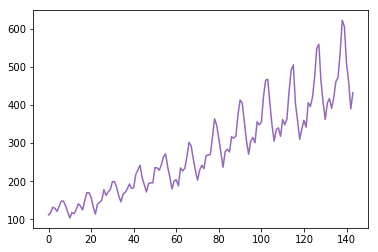

In [27]:
import matplotlib.pyplot as plt
plt.plot(dataset)
plt.show()

In [28]:

1
2
3
4
5
6
7
8
9
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [29]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [30]:
# load the dataset
dataframe = pandas.read_csv(os.path.join(*path,filename), usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [34]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [36]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [37]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [38]:

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [39]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1s - loss: 0.0414
Epoch 2/100
0s - loss: 0.0202
Epoch 3/100
0s - loss: 0.0146
Epoch 4/100
0s - loss: 0.0131
Epoch 5/100
0s - loss: 0.0121
Epoch 6/100
0s - loss: 0.0111
Epoch 7/100
0s - loss: 0.0102
Epoch 8/100
0s - loss: 0.0093
Epoch 9/100
0s - loss: 0.0081
Epoch 10/100
0s - loss: 0.0071
Epoch 11/100
0s - loss: 0.0062
Epoch 12/100
0s - loss: 0.0053
Epoch 13/100
0s - loss: 0.0045
Epoch 14/100
0s - loss: 0.0038
Epoch 15/100
0s - loss: 0.0033
Epoch 16/100
0s - loss: 0.0029
Epoch 17/100
0s - loss: 0.0026
Epoch 18/100
0s - loss: 0.0024
Epoch 19/100
0s - loss: 0.0022
Epoch 20/100
0s - loss: 0.0022
Epoch 21/100
0s - loss: 0.0021
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0021
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0021
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0020
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0021
Epoch 31/100
0s - loss: 0.0020
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

In [40]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.93 RMSE
Test Score: 47.53 RMSE


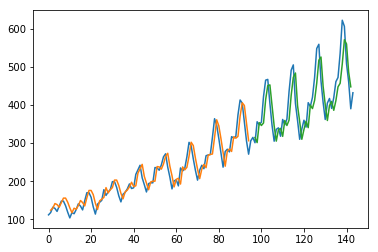

In [41]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()